<font color="#CA3532" size=5><b>Clasificación de imágenes hiperespectrales de satélite - Dataset B2<b></font><br>
<font color="#6E6E6E"><b>Machine Learning 1. Trabajo final - Máster en Ciencia de Datos</b></font><br><br>
<font color="#252525">Oriol de la Pau Chacón Albero<br>Sergio Manuel Conde Sánchez</font>

In [1]:
import numpy as np
import scipy.io.matlab as matlab
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from itertools import repeat
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.cluster import SpectralClustering

from sklearn.feature_selection import SelectFromModel
from sklearn_extra.cluster import KMedoids
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.svm import SVC

#validation
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score, adjusted_mutual_info_score

In [2]:
mat_file =  "datasetB2.mat"
mat = matlab.loadmat(mat_file,squeeze_me=True) #devuelve un dictionary
list(mat.keys()) #variables almacenadas

# Lectura de los datos
X = mat["X"]   #imagen (hipercubo 3D: filas x columnas x variables) 
Xl = mat["Xl"]   #muestras etiquetadas (muestas x variables) 
Yl = mat["Yl"]   #etiquetas de clases (muestras x 1, 0=sin clase)   
del mat
#Yl.shape

# Reshape del Ground Truth como una imagen
Y = np.reshape(Yl, (X.shape[0], X.shape[1]),order="F")
#Y.shape

#Filter background: eliminamos la clase 0 de los datos etiquetados
Nc=Yl.max()-Yl.min()+1
if Nc>2:
    Xl = Xl[Yl != 0,:];
    Yl = Yl[Yl != 0];
    
X1 = X.reshape((111104,224))
Y1 = Y.reshape((111104,))

(<matplotlib.image.AxesImage at 0x265f35d4d00>,
 (-0.5, 511.5, 216.5, -0.5),
 Text(0.5, 1.0, 'Ground Truth'))

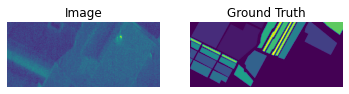

In [3]:
# Dibujamos las imagenes
ax=plt.subplot(1,2,1)
ax.imshow(X[:,:,1]), ax.axis('off'), plt.title('Image')
ax=plt.subplot(1,2,2)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')

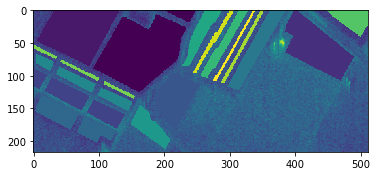

In [122]:
# Dibujamos los resultados
clasmap=Y; #aqui deberiamos poner nuestra clasificacion
clasmap_masked = np.ma.masked_where(clasmap<1,clasmap)
plt.imshow(X[:,:,1])
plt.imshow(clasmap_masked)

# Métodos no Supervisados

Comenzaremos aplicando métodos no supervisados de clustering a nuestra imagen. Esto representa un problema típico en el análisis de imágenes de satélite, en el cual la mayoría de muestras no suelen estar etiquetadas. En este caso, prescindiremos del conjunto etiquetado y nos centraremos en la imagen completa, intentando encontrar la mejor segmentación de la misma. De este modo, probaremos distintos métodos no supervisados e intentaremos seleccionar el mejor y desarrollar un proceso que podamos aplicar a otro tipo de imágenes hiperespectrales similares. 

## Determinación del número ideal de Clusters

El primer paso para hacer clustering consiste en seleccionar el número óptimo de grupos en el que queremos dividir nuestros datos. Para ello, recurriremos al método de la silueta, que nos da una medida de cuán cercanos son los puntos de cada cluster a su propio conjunto, y cuánto se alejan del resto. De esta forma, utilizaremos este método para distinto número de clusters y elegiremos el mejor. Pero antes de comenzar con ello, debido a la cantidad de procesos que requiere el método y de los datos que tenemos, comenzaremos haciendo PCA con los datos originales para reducir su dimensionalidad.

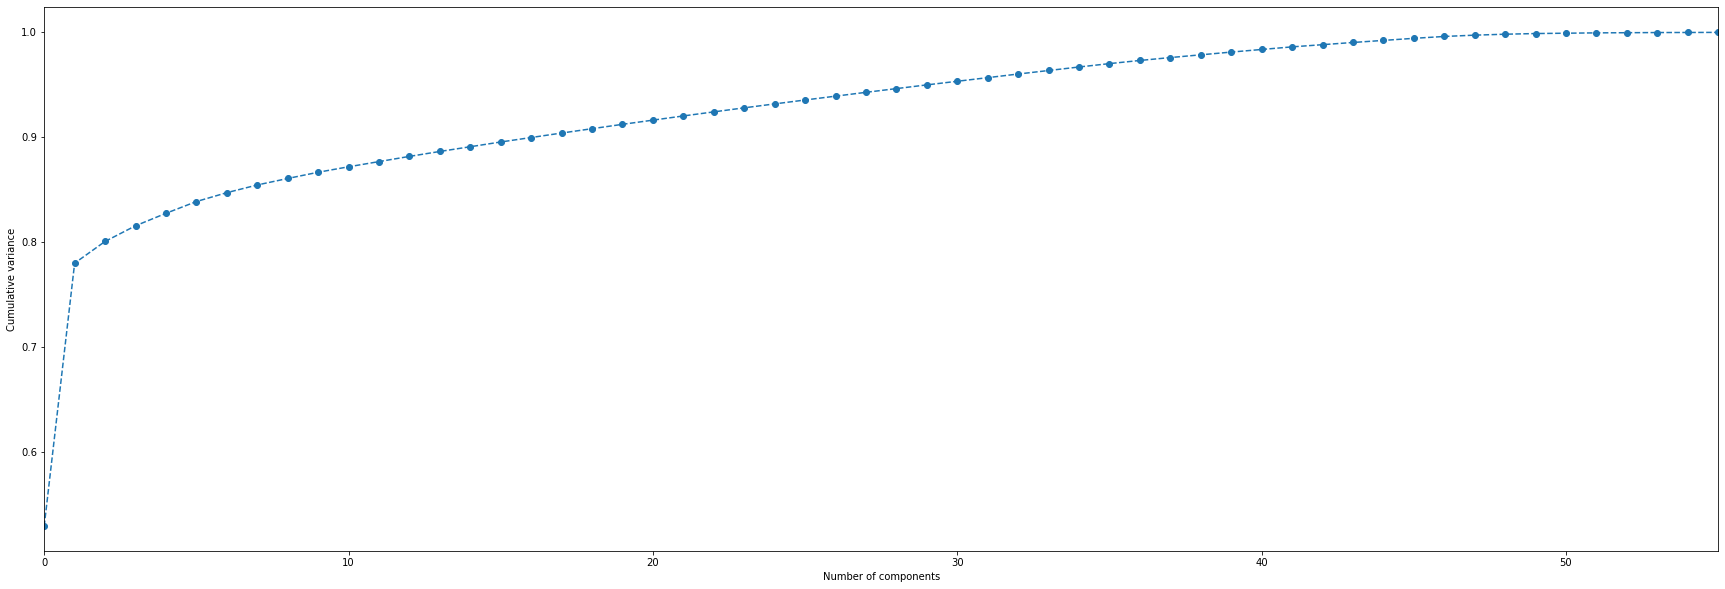

In [26]:
X_std = StandardScaler().fit_transform(X1)
pca = PCA().fit(X_std)

plt.figure(figsize = (30, 10))
plt.xlim(0, 55)
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), marker = "o", linestyle = "--")
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")
plt.show()

Elegiremos por tanto, 5 variables, que nos explican más de un 80% de la varianza y hemos encontrado, además, probando con k_means que es el número que mejores resultados nos da.

Pasamos ahora a sacar los coefcicientes de la silueta utilizando como clusterer el método k_means.

For n_clusters = 4 The average silhouette_score is : 0.4981706874678765
For n_clusters = 5 The average silhouette_score is : 0.5161923749649507
For n_clusters = 6 The average silhouette_score is : 0.48311651271044426
For n_clusters = 15 The average silhouette_score is : 0.37312248303258855
For n_clusters = 17 The average silhouette_score is : 0.3507101840344715
For n_clusters = 20 The average silhouette_score is : 0.3817674379321507


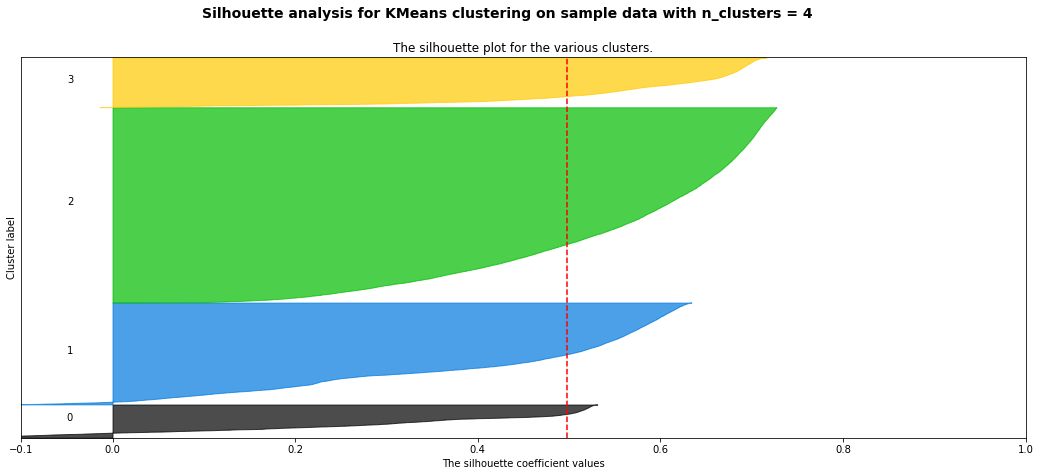

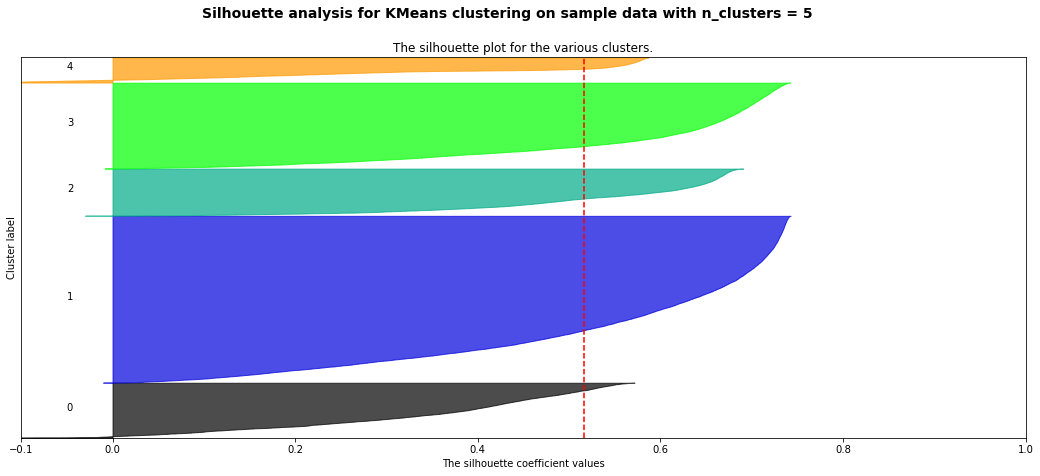

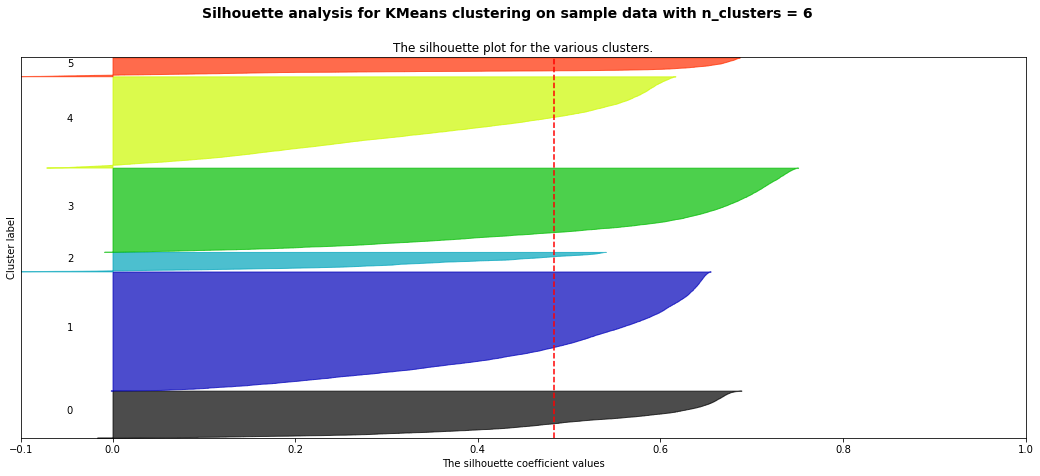

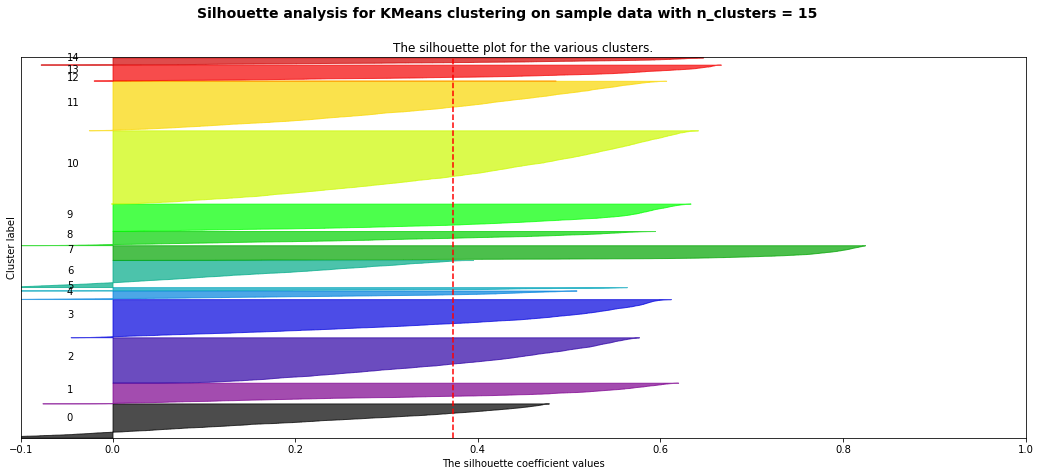

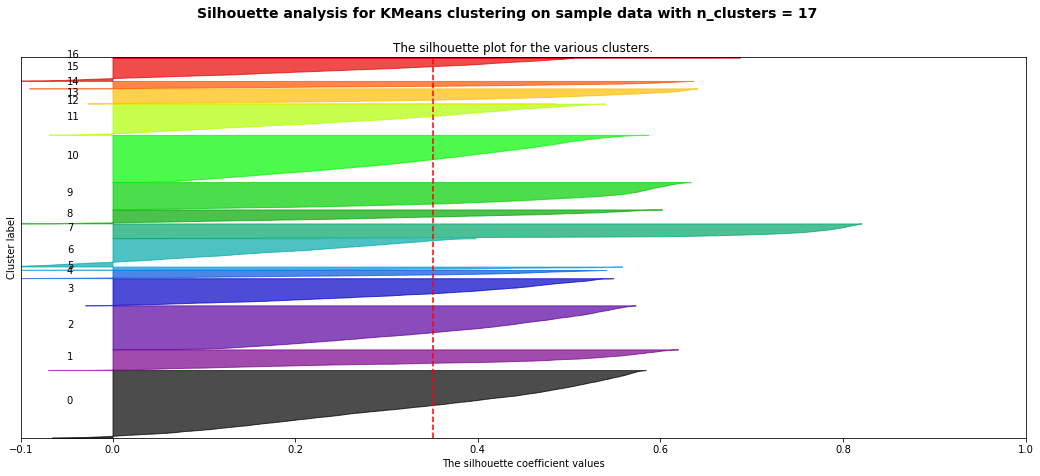

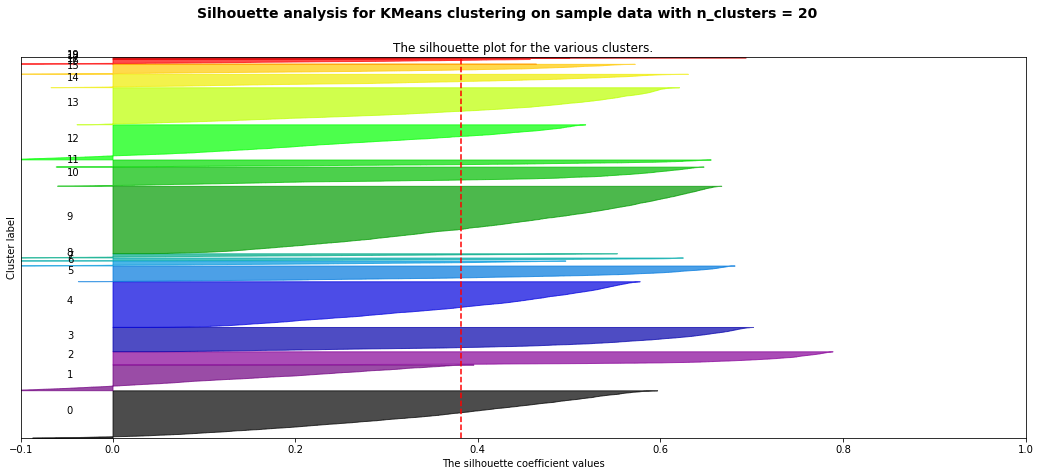

In [27]:
import matplotlib.cm as cm

pca_scores = PCA(n_components = 5).fit_transform(X_std)

range_n_clusters = [4,5,6, 15,  17, 20]
# reducimos la cantidad de datos para agilizar el proceso
pca_sample, _, _, _ = train_test_split(pca_scores, Y1, train_size=0.3) 

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(pca_sample) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(pca_sample)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pca_sample, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pca_sample, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Observamos por tanto, que con k-means, los mejores resultados se obtienen utilizando 5 clusters. Continuaremos, entonces, probando distintos métodos de clustering para comparar los resultados.

## Comparación métodos

Ahora probaremos los distintos métodos y los compararemos entre ellos. Una de las particularidades del aprendizaje no supervisado es que no tenemos conjunto de validación ni etiquetas, por tanto, se nos hace imposible confirmar cuán correcta es la solución. La estrategia que utilizaremos será la de comparar los métodos entre ellos utilizando el adjusted mutual information.

### k-means con PCA

Comenzaremos haciendo k-means con PCA, para después compararlo con dicho método sin hacer PCA. De nuevo, elegiremos cinco variables de la PCA

(<matplotlib.image.AxesImage at 0x27419324370>,
 (-0.5, 511.5, 216.5, -0.5),
 Text(0.5, 1.0, 'Predicted'))

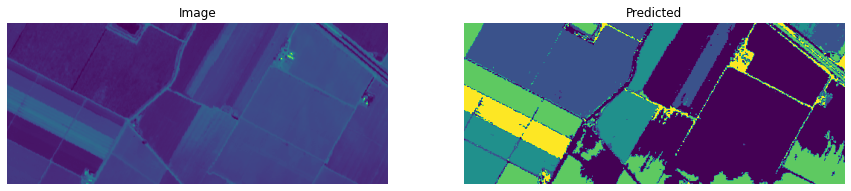

In [28]:
pca_scores = PCA(n_components = 5).fit_transform(X_std)

km = KMeans(n_clusters = 5).fit(pca_scores)

y_preds =  km.labels_
y_preds_PCA = y_preds.reshape(X[:,:,0].shape)

plt.figure(figsize = (15, 10))

ax=plt.subplot(1,2,1)
ax.imshow(X[:,:,20]), ax.axis('off'), plt.title('Image')
ax=plt.subplot(1,2,2)
ax.imshow(y_preds_PCA), ax.axis('off'), plt.title('Predicted')

### K-means (sin PCA)

Por otro lado, probaremos otra vez sin utilizar PCA pero estandarizando los datos, ya que es un paso que suele dar mejoras para k-means.

In [29]:
model = KMeans(n_clusters=5)
model.fit(X_std)
y_preds =  model.labels_
y_preds_No = y_preds.reshape(X[:,:,0].shape)

adjusted mutual info: 0.9907556374887693


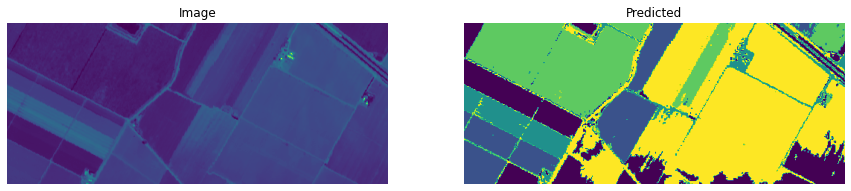

In [30]:
plt.figure(figsize = (15, 10))

ax=plt.subplot(1,2,1)
ax.imshow(X[:,:,20]), ax.axis('off'), plt.title('Image')
ax=plt.subplot(1,2,2)
ax.imshow(y_preds_No), ax.axis('off'), plt.title('Predicted')

#mutual info entre PCA y NO PCA
print('adjusted mutual info:', adjusted_mutual_info_score(y_preds_PCA.reshape(-1,), y_preds_No.reshape(-1,)))

Vemos entonces una gran simulitud entre ambos casos (99% para el adjusted mutual info), pero con la ventaja para la PCA de que solo usamos cinco variables. Por otro lado, habíamos probado también sin estandarizar los datos pero los resultados eran poco consistentes y no se veían clases claramente diferenciadas.

### Mixture con PCA

(<matplotlib.image.AxesImage at 0x27419050100>,
 (-0.5, 511.5, 216.5, -0.5),
 Text(0.5, 1.0, 'Predicted'))

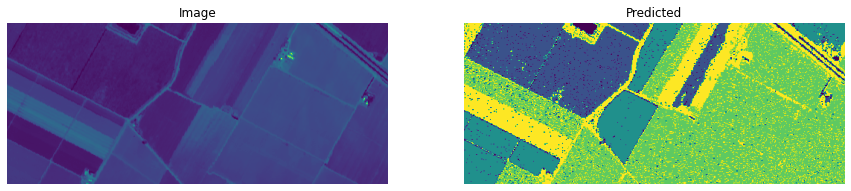

In [31]:
clf = mixture.GaussianMixture(n_components=5, covariance_type = 'full', init_params='kmeans')
y_preds = clf.fit_predict(pca_scores)
y_preds_PCA = y_preds.reshape(X[:,:,0].shape)

plt.figure(figsize = (15, 10))

ax=plt.subplot(1,2,1)
ax.imshow(X[:,:,20]), ax.axis('off'), plt.title('Image')
ax=plt.subplot(1,2,2)
ax.imshow(y_preds_PCA), ax.axis('off'), plt.title('Predicted')

### Mixture (Sin PCA)

In [32]:
clf = mixture.GaussianMixture(n_components=5, covariance_type = 'full', init_params='kmeans')
y_preds = clf.fit_predict(X_std)
y_preds_No = y_preds.reshape(X[:,:,0].shape)

adjusted mutual info: 0.4798853715645441


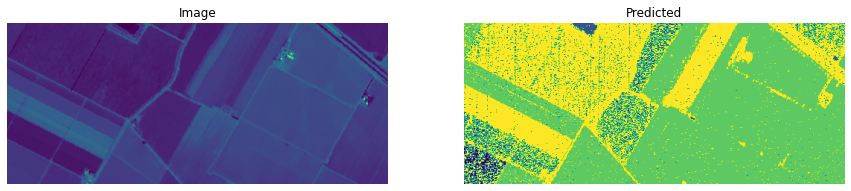

In [33]:
plt.figure(figsize = (15, 10))

ax=plt.subplot(1,2,1)
ax.imshow(X[:,:,20]), ax.axis('off'), plt.title('Image')
ax=plt.subplot(1,2,2)
ax.imshow(y_preds_No), ax.axis('off'), plt.title('Predicted')

print('adjusted mutual info:', adjusted_mutual_info_score(y_preds_PCA.reshape(-1,), y_preds_No.reshape(-1,)))

En este caso, las diferencias son mayores entre el clustering efectuado sobre el conjunto reducido mediante PCA y el original. Se obtienen mejores resultados a primera vista con el uso de PCA, pero aún así, aparece mucho ruido en las clases en forma de puntos mal etiquetados. Además, esta vez la diferencia en el tiempo de ejecución varía más en los dos casos, siendo mucho más larga cuando no hacemos PCA.

### Spectral clustering con PCA

El spectral clustering nos da más flexibilidad a la hora de hacer el clustering, ya que no asume una distribución esférica de los mismos, como ocurre por ejemplo, con el k-means. Sin embargo, esto hace que sea también un método mucho más complejo y lento que el k-means. Es por ello, que solo lo utilizaremos con PCA, por el tiempo que tarda en ejecutarse sin ella.

In [34]:
spectral = SpectralClustering(n_clusters = 5, assign_labels= 'kmeans',
                              affinity="nearest_neighbors" ,n_neighbors = 10).fit(pca_scores)
y_preds  = spectral.labels_
y_preds = y_preds.reshape(X[:,:,0].shape)

(<matplotlib.image.AxesImage at 0x274181114f0>,
 (-0.5, 511.5, 216.5, -0.5),
 Text(0.5, 1.0, 'Predicted'))

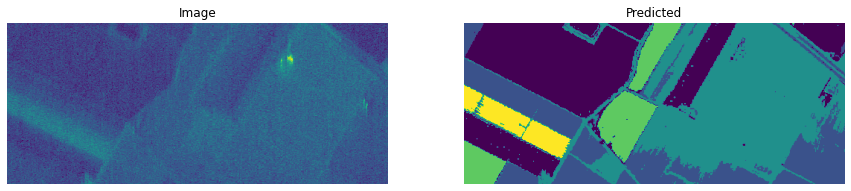

In [35]:
plt.figure(figsize = (15, 10))

ax=plt.subplot(2,2,1)
ax.imshow(X[:,:,1]), ax.axis('off'), plt.title('Image')
ax=plt.subplot(2,2,2)
ax.imshow(y_preds), ax.axis('off'), plt.title('Predicted')

Obtenemos en este caso unos resultados muy similares a los del k-means pero empleando mucho más tiempo esta vez. Es por eso que esta opción se descartaría si tuvieramos que emplearlo con una gran cantidad de imágenes.

## Conclusión

Finalmente, hemos visto cómo los resultados del gaussian mixture model son superados por los de k-means y el Spectral CLustering, los cuales proporcionan unos resultados bastante similares. Sin embargo, el método k-means es con diferencia, el más rápido y sencillo de los tres. Por tanto, si nuestro objetivo fuera utilizar uno de ellos para clasificar nuevos ejemplos parecidos, deberíamos usar K-means, para obtener resultados buenos sin un largo periodo de ejecución. Por otro lado, para agilizar aún más el entrenamiento del modelo, es necesario estandarizar y hacer PCA sobre los datos de entrada, elegiendo 5 variables representativas. De esta forma, los resultados obtenidos no variarán mucho, pero si disminuirá el tiempo de entrenamiento.

# Aprendizaje supervisado

## Obtención de un conjunto reducido y representativo de muestras

A continuación aplicaremos diferentes algoritmos de aprendizaje supervisado para clasificar nuestra imagen. Uno de los principales problemas que encontramos a la hora de utilizar algoritmos supervisados sobre imágenes hiperespectrales de satélite es la escasez de muestras etiquetadas. Para intentar recrear esta situación, estudiaremos solo un conjunto reducido de 5000 píxeles extraidos de la imágen original. Para preservar las propiedades de la imagen original (distribución desbalanceada de las clases) utilizaremos un algoritmo de clustering que seleccione muestras representativas del conjunto. 

En primer lugar calculamos cuantas muestras necesitamos de cada clase para preservar su distribución original en un subconjunto de 5000 muestras:

In [3]:
#calculamos la cantidad de muestras de cada clase
Samples = np.zeros(16)
for i in range(len(Yl)):
    Samples[Yl[i]-1] = Samples[Yl[i]-1]+1

#Calculamos la cantidad de puntos que necesitamos por etiqueta de manera que la proporción original siga igual
NumberOfCenters = np.round(Samples*5000/len(Yl))

print(NumberOfCenters)


[1072.  670.  582.  365.  352.  337.  300.  243.  186.  180.  176.  154.
  117.   95.   93.   78.]


Ahora podemos, en primer lugar, separar los datos originales por clases, y dentro de cada clase agrupar las muestras en tantos subgrupos como muestras necesitemos. Esto lo realizaremos con el algoritmo k-medioids implementado en sklearn. Este algoritmo funciona de forma similar a k-means, con la diferencia que los puntos seleccionados como centroides sí que son puntos del conjunto de datos. De este modo, seleccionando los centroides del mejor clustering, tendremos las 5000 muestras más representativas de nuestros datos, preservando la distribución de clases original.

In [4]:
#Hacemos k-medoids en cada submuestra para reducir la cantidad de etiquetas
X_reducido = []
index = []
Y_reducido = []
#A partir de k-medoids, sacamos los centros de cada cluster, 
#donde tenemos un cluster por cada punto necesario de NumberofCenters
for i in np.unique(Yl):
    km = KMedoids(n_clusters = int(NumberOfCenters[i-1])).fit(Xl[Yl == i])
    X_reducido.extend(km.cluster_centers_) #centroides de cada subconjunto
    Y_reducido.extend(repeat(i, int(NumberOfCenters[i-1]))) #etiquetas de cada centroide
    
#Por último, desordenamos las filas

X_reducido, Y_reducido = shuffle(X_reducido, Y_reducido)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 12 is empty! self.labels_[self.medoid_indices_[12]] may not be labeled with its corresponding cluster (12).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 25 is empty! self.labels_[self.medoid_indices_[25]] may not be labeled with its corresponding cluster (25).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 30 is empty! self.labels_[self.medoid_indices_[30]] may not be labeled with its corresponding cluster (30).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_me

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 981 is empty! self.labels_[self.medoid_indices_[981]] may not be labeled with its corresponding cluster (981).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 985 is empty! self.labels_[self.medoid_indices_[985]] may not be labeled with its corresponding cluster (985).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 990 is empty! self.labels_[self.medoid_indices_[990]] may not be labeled with its corresponding cluster (990).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 991 is empty! self.labels_[self.medoid_indices_[991]] may not be labeled with its corresponding cluster (991).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\c

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 32 is empty! self.labels_[self.medoid_indices_[32]] may not be labeled with its corresponding cluster (32).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 42 is empty! self.labels_[self.medoid_indices_[42]] may not be labeled with its corresponding cluster (42).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 15 is empty! self.labels_[self.medoid_indices_[15]] may not be labeled with its corresponding cluster (15).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 23 is empty! self.labels_[self.medoid_indices_[23]] may not be labeled with its corresponding cluster (23).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 24 is empty! self.labels_[self.medoid_indices_[24]] may not be labeled with its corresponding cluster (24).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_me

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 23 is empty! self.labels_[self.medoid_indices_[23]] may not be labeled with its corresponding cluster (23).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 35 is empty! self.labels_[self.medoid_indices_[35]] may not be labeled with its corresponding cluster (35).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 36 is empty! self.labels_[self.medoid_indices_[36]] may not be labeled with its corresponding cluster (36).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 38 is empty! self.labels_[self.medoid_indices_[38]] may not be labeled with its corresponding cluster (38).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_me

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 19 is empty! self.labels_[self.medoid_indices_[19]] may not be labeled with its corresponding cluster (19).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 23 is empty! self.labels_[self.medoid_indices_[23]] may not be labeled with its corresponding cluster (23).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 29 is empty! self.labels_[self.medoid_indices_[29]] may not be labeled with its corresponding cluster (29).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 31 is empty! self.labels_[self.medoid_indices_[31]] may not be labeled with its corresponding cluster (31).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_me

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 24 is empty! self.labels_[self.medoid_indices_[24]] may not be labeled with its corresponding cluster (24).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 25 is empty! self.labels_[self.medoid_indices_[25]] may not be labeled with its corresponding cluster (25).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 27 is empty! self.labels_[self.medoid_indices_[27]] may not be labeled with its corresponding cluster (27).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 28 is empty! self.labels_[self.medoid_indices_[28]] may not be labeled with its corresponding cluster (28).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_me

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 16 is empty! self.labels_[self.medoid_indices_[16]] may not be labeled with its corresponding cluster (16).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 17 is empty! self.labels_[self.medoid_indices_[17]] may not be labeled with its corresponding cluster (17).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 21 is empty! self.labels_[self.medoid_indices_[21]] may not be labeled with its corresponding cluster (21).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 25 is empty! self.labels_[self.medoid_indices_[25]] may not be labeled with its corresponding cluster (25).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_me

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 29 is empty! self.labels_[self.medoid_indices_[29]] may not be labeled with its corresponding cluster (29).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 30 is empty! self.labels_[self.medoid_indices_[30]] may not be labeled with its corresponding cluster (30).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 19 is empty! self.labels_[self.medoid_indices_[19]] may not be labeled with its corresponding cluster (19).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 29 is empty! self.labels_[self.medoid_indices_[29]] may not be labeled with its corresponding cluster (29).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 30 is empty! self.labels_[self.medoid_indices_[30]] may not be labeled with its corresponding cluster (30).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 31 is empty! self.labels_[self.medoid_indices_[31]] may not be labeled with its corresponding cluster (31).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_me

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 16 is empty! self.labels_[self.medoid_indices_[16]] may not be labeled with its corresponding cluster (16).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 22 is empty! self.labels_[self.medoid_indices_[22]] may not be labeled with its corresponding cluster (22).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 23 is empty! self.labels_[self.medoid_indices_[23]] may not be labeled with its corresponding cluster (23).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 26 is empty! self.labels_[self.medoid_indices_[26]] may not be labeled with its corresponding cluster (26).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_me

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 24 is empty! self.labels_[self.medoid_indices_[24]] may not be labeled with its corresponding cluster (24).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 26 is empty! self.labels_[self.medoid_indices_[26]] may not be labeled with its corresponding cluster (26).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 28 is empty! self.labels_[self.medoid_indices_[28]] may not be labeled with its corresponding cluster (28).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 29 is empty! self.labels_[self.medoid_indices_[29]] may not be labeled with its corresponding cluster (29).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_me

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 13 is empty! self.labels_[self.medoid_indices_[13]] may not be labeled with its corresponding cluster (13).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 15 is empty! self.labels_[self.medoid_indices_[15]] may not be labeled with its corresponding cluster (15).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 16 is empty! self.labels_[self.medoid_indices_[16]] may not be labeled with its corresponding cluster (16).
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoi

NameError: name 'shuffle' is not defined

## Decision Tree Classifier

Una vez tenemos un subconjunto reducido y representativo de 5000 muestras, utilizaremos diferentes clasificadores supervisados (árbol de decisión, KNN y Support Vector Classifier) y evaluaremos su eficacia para este problema en concreto. La estrategia desarrollada en los tres casos será la misma. En primer lugar dividimos el conjunto reducido de datos en un subconjunto de entrenamiento y otro de test. Trabajaremos únicamente con los datos de entrenamiento para construir nuestro modelo: los estandarizaremos, y utilizaremos el algoritmo GridSearch para determinar los hiperparámetros adecuados en cada caso. Finalmente, predeciremos las etiquetas del subconjunto test con el modelo seleccionado anteriormente. La comparación de este resultado con las etiquetas reales nos dará una aproximación del error del clasificador. La métrica utilizada para este fin es el coeficiente kappa de Cohen, más adecuado que la accuracy en un problema como el nuestro (con clases desbalanceadas) ya que tiene en cuenta el efecto del azar a la hora de clasificar. 

El primer clasificador utilizado es el árbol de decisión. Los hiperparámetros a optimizar serán la profundidad del árbol y el criterio utilizado a la hora de dividir el conjunto:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_reducido, Y_reducido, test_size = 0.3)

In [7]:
pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                           ('dec_tree', DecisionTreeClassifier())]) 

# posibles hiperparámetros
criterion = ['gini', 'entropy']
max_depth = range(5,25)

parameters = dict(dec_tree__criterion=criterion,
                      dec_tree__max_depth=max_depth, dec_tree__random_state=[0])

clf = GridSearchCV(pipe, parameters)
clf.fit(X_train, y_train)

print('Mejores parámetros: ', clf.best_params_)
print('Mejor modelo: ', clf.best_estimator_)
print('Mejor score: ', clf.best_score_)

y_pred_val = clf.best_estimator_.predict(X_test)
k = kappa(y_test, y_pred_val)
print('Tasa de acierto (kappa): \n', k)

Mejores parámetros:  {'dec_tree__criterion': 'entropy', 'dec_tree__max_depth': 5, 'dec_tree__random_state': 0}
Mejor modelo:  Pipeline(steps=[('std_slc', StandardScaler()),
                ('dec_tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        random_state=0))])
Mejor score:  0.9348571428571428
Tasa de acierto (kappa): 
 0.9449589051284912


Observamos que el clasificador obtenido tiene un buen rendimiento ya que obtenemos un coeficiente de kappa del 94% a la hora de clasificar datos que no había visto con anterioridad. Este resultado es muy similar al best_score_ obtenido con gridsearch, lo cual no sorprende. Efectivament, este algoritmo divide el conjunto train original en 5 subconjuntos, y mediante validación cruzada, selecciona los hiperparámetros que minimizan el error en el subconjunto de validación. Con un acierto del 94% en datos que no conoce, podemos afirmar que el clasificador es capaz de generalizar. Para demostrarlo podemos representar el coeficiente de acierto kappa en función del parámetro max_depth para los conjuntos train y test (se trata solo de una comprobación, no estamos modificando el modelo). Observamos que efectivamente, el mejor clasificador obtenido con gridsearch (5 capas) tiene un buen rendimiento prácticamente igual en el conjunto de entrenamiento y test, por lo que podemos descartar el sobreentrenamiento.

La tasa de acierto dada por el coeficiente kappa nos permite establecer una aproximación del error de nuestro clasificador, en este caso un 6%.

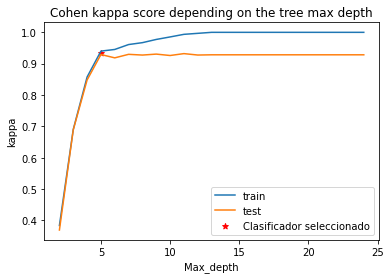

In [10]:
kappa_train = []
kappa_test = []

for i in range(2, 25, 1):
    tree = Pipeline(steps=[('std_slc', StandardScaler()),
                           ('tree_dec', DecisionTreeClassifier(max_depth = i, criterion = 'entropy', random_state = 0))])
    tree.fit(X_train, y_train)
    y_pred_train = tree.predict(X_train)
    y_pred_test = tree.predict(X_test)
    
    kappa_train.append(kappa(y_pred_train, y_train))
    kappa_test.append(kappa(y_pred_test, y_test))
    
plt.plot(range(2,25,1), kappa_train, label = 'train')
plt.plot(range(2,25,1), kappa_test, label = 'test')
plt.scatter(clf.best_params_['dec_tree__max_depth'], k, marker = '*', c = 'red', label = 'Clasificador seleccionado')
plt.title('Cohen kappa score depending on the tree max depth')
plt.xlabel('Max_depth')
plt.ylabel('kappa')
plt.legend()
plt.show()

También podemos aplicar este clasificador para predecir las etiquetas del conjunto original, para una comparación cualitativa visual.

(<matplotlib.image.AxesImage at 0x293a1fd7670>,
 (-0.5, 511.5, 216.5, -0.5),
 Text(0.5, 1.0, 'Prediction of labels'))

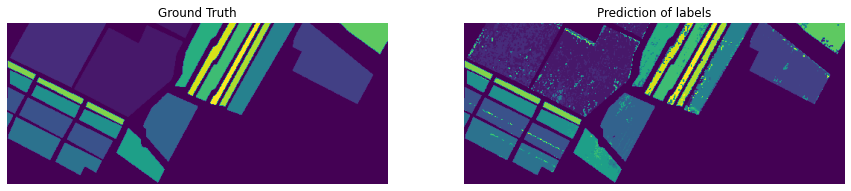

In [39]:
y_aux = Y1.copy()

y_pred = clf.best_estimator_.predict(X1[Y1 !=0])
y_aux[Y1 != 0] = y_pred
y_pred = y_aux.reshape(Y.shape)


# Dibujamos las imagenes
plt.figure(figsize = (15, 10))

ax=plt.subplot(1,2,1)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')
ax=plt.subplot(1,2,2)
ax.imshow(y_pred), ax.axis('off'), plt.title('Prediction of labels')

También podemos representar la matriz de confusión para comparar las etiquetas predichas con las originales, identificando las clases en las que suele fallar:

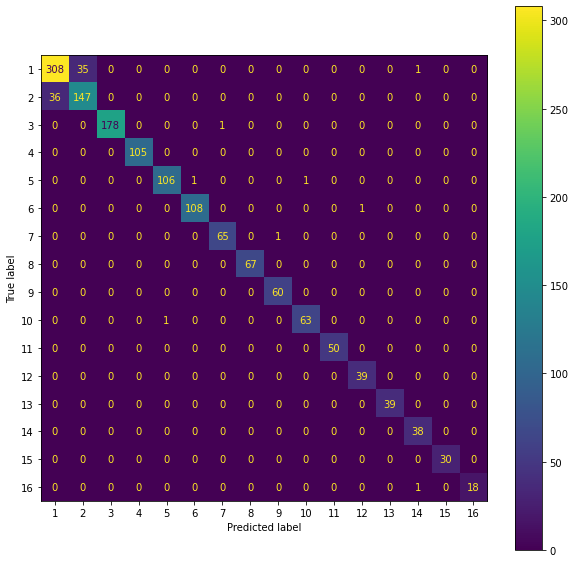

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf.best_estimator_, X_test, y_test, ax = ax)
plt.show()

## KNN

Utilizaremos ahora el algoritmo k-vecinos más próximos. En este caso, los hiperparámetros a optimizar serán el número de vecinos que 'votan', así como si el 'voto' está pesado por la distancia o no. Para determinar el número de vecinos k hemos empezado cubriendo un intervalo más amplio de posibles valores (siempre impares), y después nos hemos centrado en la zona que mejores resultados daba:

In [44]:
pipe2 = Pipeline(steps=[('std_slc', StandardScaler()),
                           ('knn_class', KNeighborsClassifier())]) 

#n_neighbors = [5, 15, 31, 45, 61, 71, 85, 91, 101, 125]
n_neighbors = range(31,61,2)
weights = ['uniform', 'distance']

parameters2 = dict(knn_class__n_neighbors = n_neighbors,
                      knn_class__weights = weights)

knn = GridSearchCV(pipe2, parameters2)
knn.fit(X_train, y_train)

print('Mejores parámetros: ', knn.best_params_)
print('Mejor modelo: ', knn.best_estimator_)
print('Mejor score: ', knn.best_score_)

y_pred_val = knn.best_estimator_.predict(X_test)
print('Tasa de acierto kappa: \n', kappa(y_test, y_pred_val))

Mejores parámetros:  {'knn_class__n_neighbors': 47, 'knn_class__weights': 'distance'}
Mejor modelo:  Pipeline(steps=[('std_slc', StandardScaler()),
                ('knn_class',
                 KNeighborsClassifier(n_neighbors=47, weights='distance'))])
Mejor score:  0.9217142857142857
Tasa de acierto kappa: 
 0.9273840852865185


Los hiperparámetros que minimizan el error para datos no conocidos son k = 47 vecinos, con voto pesado por la distancia. El error del clasificador sería 7.3% en datos que no conoce.

(<matplotlib.image.AxesImage at 0x293a1039c40>,
 (-0.5, 511.5, 216.5, -0.5),
 Text(0.5, 1.0, 'Prediction of labels'))

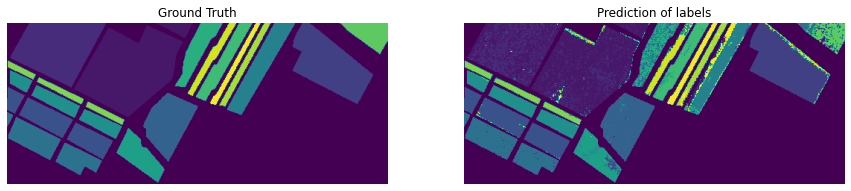

In [30]:
# evaluación cualitativa visual
y_aux = Y1.copy()

y_pred = knn.best_estimator_.predict(X1[Y1 !=0])
y_aux[Y1 != 0] = y_pred
y_pred = y_aux.reshape(Y.shape)


# Dibujamos las imagenes
plt.figure(figsize = (15, 10))

ax=plt.subplot(1,2,1)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')
ax=plt.subplot(1,2,2)
ax.imshow(y_pred), ax.axis('off'), plt.title('Prediction of labels')

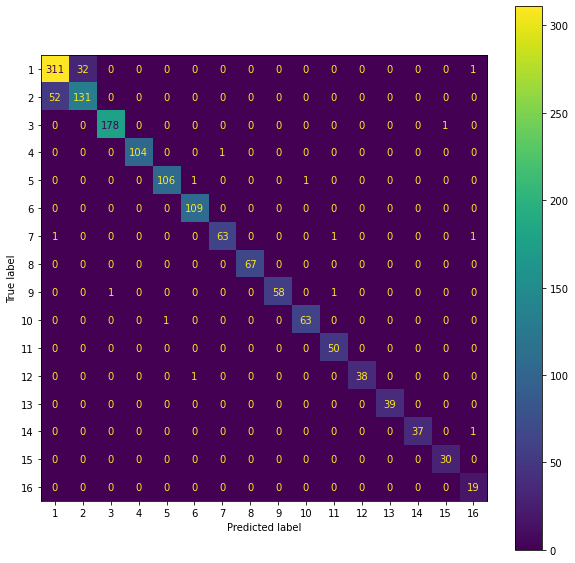

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(knn.best_estimator_, X_test, y_test, ax = ax)
plt.show()

## SVM

Finalmente utilizaremos un clasificador de tipo Support Vector Machine, con un kernel gaussiano o lineal:

In [31]:
tuned_parameters = [
    {"svm_class__kernel": ["rbf"], "svm_class__gamma": [1e-3, 1e-4], "svm_class__C": [1, 10, 100, 1000]},
    {"svm_class__kernel": ["linear"], "svm_class__C": [1, 10, 100, 1000]},
]

pipe3 = Pipeline(steps=[('std_slc', StandardScaler()),
                           ('svm_class', SVC())]) 


svc = GridSearchCV(pipe3, tuned_parameters)
X_train, X_test, y_train, y_test = train_test_split(X_reducido, Y_reducido, test_size = 0.3)
svc.fit(X_train, y_train)

print('Mejores parámetros: ', svc.best_params_)
print('Mejor modelo: ', svc.best_estimator_)
print('Mejor score: ', svc.best_score_)

y_pred_val = svc.best_estimator_.predict(X_test)
print('Error clasificación: \n', kappa(y_test, y_pred_val))

Mejores parámetros:  {'svm_class__C': 10, 'svm_class__kernel': 'linear'}
Mejor modelo:  Pipeline(steps=[('std_slc', StandardScaler()),
                ('svm_class', SVC(C=10, kernel='linear'))])
Mejor score:  0.940857142857143
Error clasificación: 
 0.9439486739252718


El kernel lineal escogido es hasta el momento el clasificador con mejor rendimiento, con un coeficiente kappa del 94.4% de acierto. Por lo tanto, tendría una tasa de error del 6%.

(<matplotlib.image.AxesImage at 0x293a0691190>,
 (-0.5, 511.5, 216.5, -0.5),
 Text(0.5, 1.0, 'Prediction of labels'))

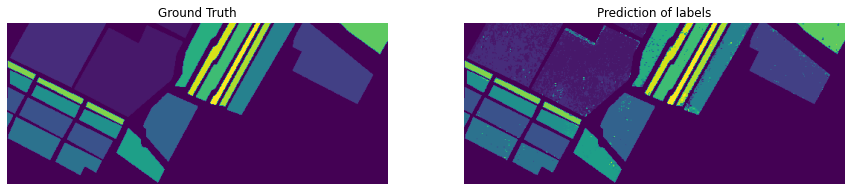

In [33]:
# evaluación cualitativa visual
y_aux = Y1.copy()

y_pred = svc.best_estimator_.predict(X1[Y1 !=0])
y_aux[Y1 != 0] = y_pred
y_pred = y_aux.reshape(Y.shape)


# Dibujamos las imagenes
plt.figure(figsize = (15, 10))

ax=plt.subplot(1,2,1)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')
ax=plt.subplot(1,2,2)
ax.imshow(y_pred), ax.axis('off'), plt.title('Prediction of labels')

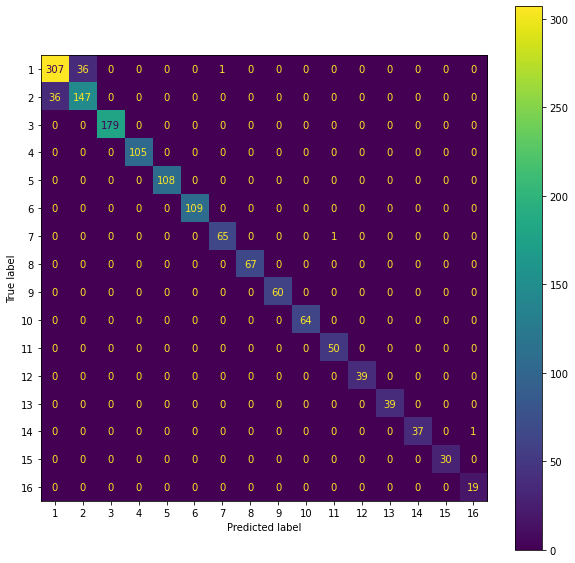

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(svc.best_estimator_, X_test, y_test, ax = ax)
plt.show()

## Selección de características

La imagen puede contener bandas con datos erróneos, o bandas que tengan poca relevancia en el resultado de la clasificación. Nos quedaremos solamente con aquellas características importantes. Esto reducirá el peso computacional de los cálculos y puede mejorar la clasificación.

La selección de caracteristicas relevantes se puede hacer de varias formas. En nuestro caso, lo haremos usando el método proporcionado en scikit-learn, SelectFromModel. De este modo, usaremos un clasificador para determinar las bandas con mayor importancia y a continuación, entrenaremos otro nuevo modelo utilizando solo las escogidas. Esto lo haremos aprovechando el árbol clasifcador que ya entrenamos en el apartado anterior.

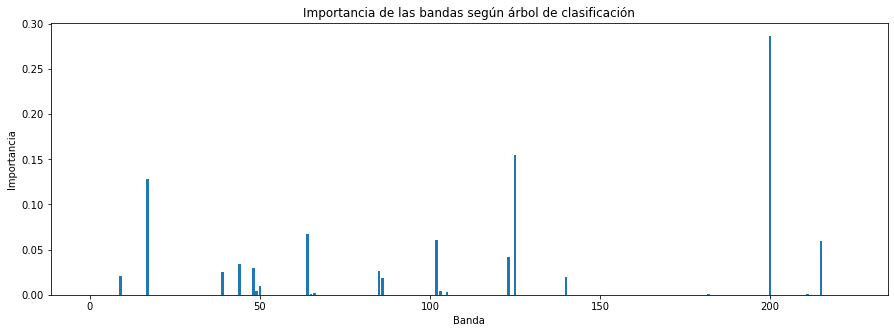

In [8]:
importance = clf.best_estimator_[1].feature_importances_

plt.figure(figsize = (15, 5))
plt.bar([x for x in range(len(importance))], importance)

plt.xlabel("Banda")
plt.ylabel("Importancia")
plt.title("Importancia de las bandas según árbol de clasificación")
plt.show()

In [19]:
#creamos el selector que nos transformará los conjuntos
selector_tr = SelectFromModel(clf.best_estimator_[1], prefit=True)
X_reducido_sc = selector_tr.transform(X_reducido)
Xl_sc = selector_tr.transform(Xl)

print(f"Number of features selected: {Xl_sc.shape[1]}\n")

X_train, X_test, y_train, y_test = train_test_split(X_reducido_sc, Y_reducido, test_size = 0.4)

clf2 = DecisionTreeClassifier(max_depth = 5, criterion = 'entropy', random_state = 0)
clf2.fit(StandardScaler().fit_transform(X_train), y_train)

y_pred_val = clf2.predict(StandardScaler().fit_transform(X_test))
k = kappa(y_test, y_pred_val)
print('Tasa de acierto (kappa): \n', k)

Number of features selected: 15

Tasa de acierto (kappa): 
 0.9279776055367216


En este caso la tasa de error no parece haber mejorado.

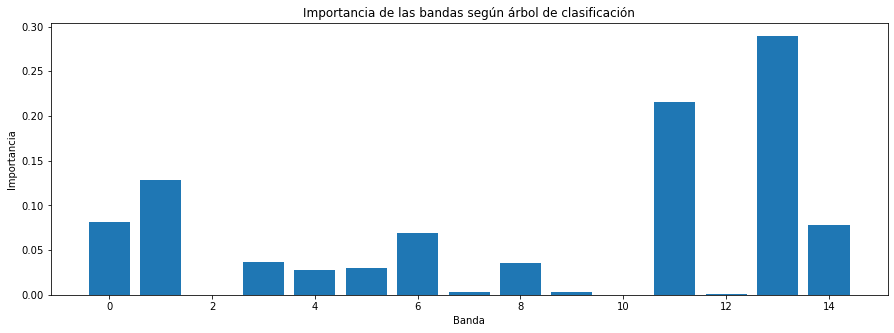

In [63]:
importance = clf2.feature_importances_

plt.figure(figsize = (15, 5))
plt.bar([x for x in range(len(importance))], importance)

plt.xlabel("Banda")
plt.ylabel("Importancia")
plt.title("Importancia de las bandas según árbol de clasificación")
plt.show()

(<matplotlib.image.AxesImage at 0x293a06a41f0>,
 (-0.5, 511.5, 216.5, -0.5),
 Text(0.5, 1.0, 'Prediction of labels'))

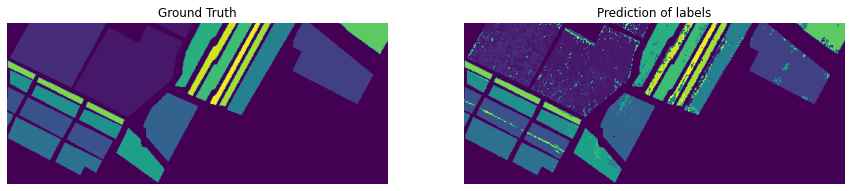

In [64]:
#Mostramos la imagen con las clases estimadas para todas las muestras para una comparación cualitativa visual.
y_aux = Y1.copy()

X1_sc = selector_tr.transform(X1)

y_pred = clf2.predict( StandardScaler().fit_transform(X1_sc[Y1 !=0]))
y_aux[Y1 != 0] = y_pred
y_pred = y_aux.reshape(Y.shape)


# Dibujamos las imagenes
plt.figure(figsize = (15, 10))

ax=plt.subplot(1,2,1)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')
ax=plt.subplot(1,2,2)
ax.imshow(y_pred), ax.axis('off'), plt.title('Prediction of labels')

## SVM

In [21]:
tuned_parameters2 = [
    {"svm_class__kernel": ["rbf"], "svm_class__gamma": [1e-3, 1e-4], "svm_class__C": [1, 10, 100, 1000]},
    {"svm_class__kernel": ["linear"], "svm_class__C": [1, 10, 100, 1000]},
]

pipe4 = Pipeline(steps=[('std_slc', StandardScaler()),
                           ('svm_class', SVC())]) 


svc2 = GridSearchCV(pipe4, tuned_parameters2)

svc2.fit(X_train, y_train)

print('Mejores parámetros: ', svc2.best_params_)
print('Mejor modelo: ', svc2.best_estimator_)
print('Mejor score: ', svc2.best_score_)

y_pred_val = svc2.best_estimator_.predict(X_test)
print('Error clasificación: \n', kappa(y_test, y_pred_val))

Mejores parámetros:  {'svm_class__C': 100, 'svm_class__kernel': 'linear'}
Mejor modelo:  Pipeline(steps=[('std_slc', StandardScaler()),
                ('svm_class', SVC(C=100, kernel='linear'))])
Mejor score:  0.95
Error clasificación: 
 0.92477072615618


(<matplotlib.image.AxesImage at 0x274184575b0>,
 (-0.5, 511.5, 216.5, -0.5),
 Text(0.5, 1.0, 'Prediction of labels'))

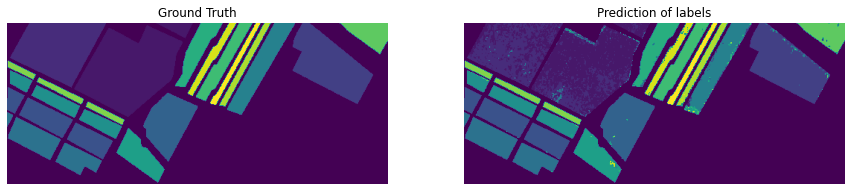

In [23]:
#Mostramos la imagen con las clases estimadas para todas las muestras para una comparación cualitativa visual.
y_aux = Y1.copy()

X1_sc = selector_tr.transform(X1)

y_pred = svc2.predict(X1_sc[Y1 !=0])
y_aux[Y1 != 0] = y_pred
y_pred = y_aux.reshape(Y.shape)


# Dibujamos las imagenes
plt.figure(figsize = (15, 10))

ax=plt.subplot(1,2,1)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')
ax=plt.subplot(1,2,2)
ax.imshow(y_pred), ax.axis('off'), plt.title('Prediction of labels')

En principio, la selección de características no implica una mejora del rendimiento del clasificador, más bien un aumento de pocas unidades porcentuales de la tasa de error (2% aproximadamente). Sin embargo, teniendo en cuenta el alto coste tanto económico como computacional de adquirir, almacenar y procesar grandes conjuntos de datos, si con únicamente 15 características somos capaces de obtener resultados casi tan buenos como con las 224 originales, esta reducción de la dimensionalidad constituye una ventaja importante en términos de costes y tiempo invertido.

## Ensemble

Probaremos ahora con los métodos ensemble, que se encargan de combinar varios métodos de clasificación para hacerlos mejorar su rendimiento.

### Random Forest

Comenzamos con el Random Forest, que no es más que un conjunto de árboles:

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score as kappa

X_train, X_test, y_train, y_test = train_test_split(X_reducido_sc, Y_reducido, test_size = 0.3, random_state = 0)

#Pruebo varios tunnings, pero únicamente n_estimators mejora algo al aumentarlo
rf = RandomForestClassifier(max_depth = 12, random_state = 0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(kappa(y_test, y_pred))

0.9458737776494786


Obtenemos unos resultados ligeramente mejores que con el árbol de decisión y sin aumentar en gran medida el tiempo de ejecución.

(<matplotlib.image.AxesImage at 0x274185233d0>,
 (-0.5, 511.5, 216.5, -0.5),
 Text(0.5, 1.0, 'Prediction of labels'))

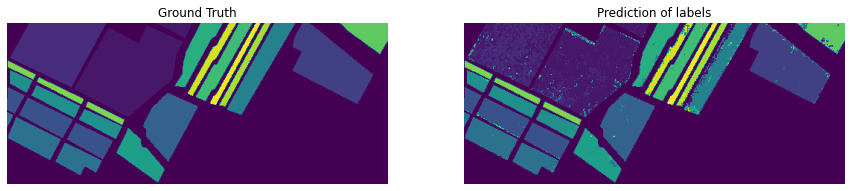

In [38]:
#Mostramos la imagen con las clases estimadas para todas las muestras para una comparación cualitativa visual.
y_aux = Y1.copy()

X1_sc = selector_tr.transform(X1)

y_pred = rf.predict(X1_sc[Y1 !=0])
y_aux[Y1 != 0] = y_pred
y_pred = y_aux.reshape(Y.shape)


# Dibujamos las imagenes
plt.figure(figsize = (15, 10))

ax=plt.subplot(1,2,1)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')
ax=plt.subplot(1,2,2)
ax.imshow(y_pred), ax.axis('off'), plt.title('Prediction of labels')

### Adaboost

Probaremos ahora con el Adaboost, que incorpora un conjunto de métodos de clasificación que va entrenando sobre el dataset. Su particularidad es que en cada iteración actualiza los pesos que le da a cada muestra de entrenamiento, de modo que le da mayor importancia a aquellas que más le cuesta a nuestro método de clasificación.

In [39]:
from sklearn.ensemble import AdaBoostClassifier

base = RandomForestClassifier()
AB = AdaBoostClassifier(base_estimator = base, n_estimators=100, random_state = 0)
AB.fit(X_train, y_train)
y_pred = AB.predict(X_test)

print(kappa(y_test, y_pred))

0.9458562475956712


(<matplotlib.image.AxesImage at 0x27418702d60>,
 (-0.5, 511.5, 216.5, -0.5),
 Text(0.5, 1.0, 'Prediction of labels'))

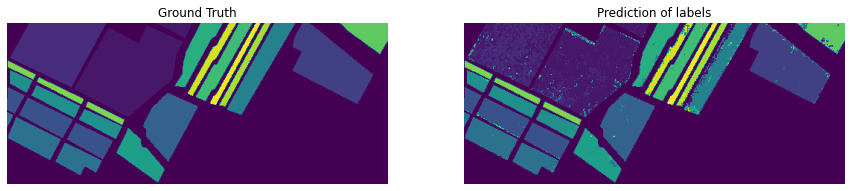

In [40]:
#Mostramos la imagen con las clases estimadas para todas las muestras para una comparación cualitativa visual.
y_aux = Y1.copy()

X1_sc = selector_tr.transform(X1)

y_pred = rf.predict(X1_sc[Y1 !=0])
y_aux[Y1 != 0] = y_pred
y_pred = y_aux.reshape(Y.shape)


# Dibujamos las imagenes
plt.figure(figsize = (15, 10))

ax=plt.subplot(1,2,1)
ax.imshow(Y), ax.axis('off'), plt.title('Ground Truth')
ax=plt.subplot(1,2,2)
ax.imshow(y_pred), ax.axis('off'), plt.title('Prediction of labels')

Obtenemos en este caso unos resultados muy similares a los de random Forest, pero quizá, con un periodo más largo de computación. Observamos que en este problema concreto, un simple árbol de decisión ya daba buenos resultados, por lo que no cabría esperar que los métodos ensemble significaran una mejora considerable. Ahora bien, estos métodos son más robustos, con mejor capacidad de generalizar a datos nuevos por lo cual son preferibles a los clasificadores simples presentados en el apartado anterior.

# Conclusión

Con este trabajo hemos abordado los diferentes métodos de aprendizaje supervisado y no supervisado tratados en la asignatura de Machine Learning 1, enfocados al tratamiento de imágenes hiperespectrales.

En primer lugar, se han abordado diferentes métodos para reducir la dimensionalidad del conjunto de datos originales (análisis de componentes principales y selección de características relevantes en un clasificador). Este paso es muy importante, ya que actualmente se trabaja con conjuntos muy grandes de datos, y la selección de características necesarias permite reducir en gran medida los costes computacionales, económicos y temporales de cualquier proyecto. Por ejemplo, si se plantea monitorizar mediante imágenes hiperespectrales los campos de cultivo de un país como el nuestro, resultaría prohibitivo utilizar todas las bandas del espectro incluyendo aquellas que no aportan ninguna información.

A continuación, dada la naturaleza no etiquetada de la mayoría de los datasets de imágenes hiperespectrales, hemos utilizado diferentes algoritmos de aprendizaje no supervisado para clasificar los datos en diferentes grupos. El número óptimo de grupos encontrado es de 5 clusters (coeficiente Silouette), diferente de las 16 clases que sabemos tiene el problema. Esto demuestra las limitaciones de agrupar muestras sin conocer el número de clusters de antemano, cuando las características de varios grupos son similares. Los mejores resultados se han conseguido mediante los algoritmos k-means y Spectral Cluster, siendo preferible el primero dado su menor tiempo de ejecución.

Seguidamente hemos utilizado diferentes clasificadores supervisados ya que tenemos la etiqueta correspondiente a cada píxel. Hemos utilizado el algoritmo k-medoids para seleccionar únicamente 5000 muestras representativas del conjunto (con el mismo desbalanceo de clases) con tal de simular la situación típica en el análisis de imágenes de satélite, en las cuales las muestras etiquetadas son escasas. En los tres clasificadores utilizados (knn, árbol de decisión y SVM) hemos dividido el conjunto de datos reducido en un subconjunto de entrenamiento y otro de test. Hemos optimizado los hiperparámetros de cada clasificador mediante un gridsearch sobre el conjunto de entrenamiento (el cual utiliza el método de validación cruzada) y finalmente hemos validado el clasificador obtenido con el conjunto de test, obteniendo un error menor del 10 % en todos los casos. El clasificador con mejor rendimiento ha sido el SVM con un 94.4% (kappa), ligeramente por encima de los otros dos. 

Finalmente, hemos recurrido a los métodos ensemble para intentar mejorar aún más el rendimiento de nuestro modelo. De esta forma, hemos probado un random Forest y un Adaboost con random forest como estimador base. En ambos casos, los resultados han sido muy similares  a los ya obtenidos anteriormente (94.6 kappa score en ambos casos). Aún así, el tiempo de computación no es mucho más largo y se trata de métodos más robustos, por lo que sería recomendable recurrir a ellos para el análisis de otro tipo de imágenes como la que hemos tratado. 

Además, hemos podido comprobar cualitativamente la validez de nuestros modelos: cuando se aplican sobre la imágen completa, el mapa obtenido es muy similar al GroundTruth. Al intentar determinar la causa del error mediante la matriz de confusión, vemos que en general aparecen muy pocos errores fruto del azar en la mayoría de clases. Sin embargo, todos los clasificadores arrojan sistemáticamente confusión significativa entre las clases 1 y 2, por lo que si quisiéramos mejorar el clasificador deberíamos profundizar en esto.